<a href="https://colab.research.google.com/github/IanVlasov/NN_intro/blob/lesson_6/Vlasov_Ian_HW06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Код с урока**

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [278]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14243895121803764203, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 236567043028080377
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7975122975777494699
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150664704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7217826214951025907
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [279]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [280]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-znk_5zh5
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-znk_5zh5
  Created wheel for tensorflow-examples: filename=tensorflow_examples-e3457d879907047d40c448241da8a54709bef008_-cp36-none-any.whl size=116517 sha256=a857bf25f6e5b0441fb5cc5fc12aa0ef240ddc0a1f4a91e35a3ca37c73d0fcc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-jxuw9y5f/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf

In [282]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(
      allow_soft_placement=True, log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [283]:
builder = tfds.builder('oxford_iiit_pet:3.1.0')
info = builder.info
print(info)
config = tfds.download.DownloadConfig(register_checksums = True)
builder.download_and_prepare(download_config=config)
dataset = builder.as_dataset()

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and J

In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
with tf.device('/gpu:0'):
  train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test = dataset['test'].map(load_image_test)

In [0]:
with tf.device('/gpu:0'):  
  train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
  train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  test_dataset = test.batch(BATCH_SIZE)

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

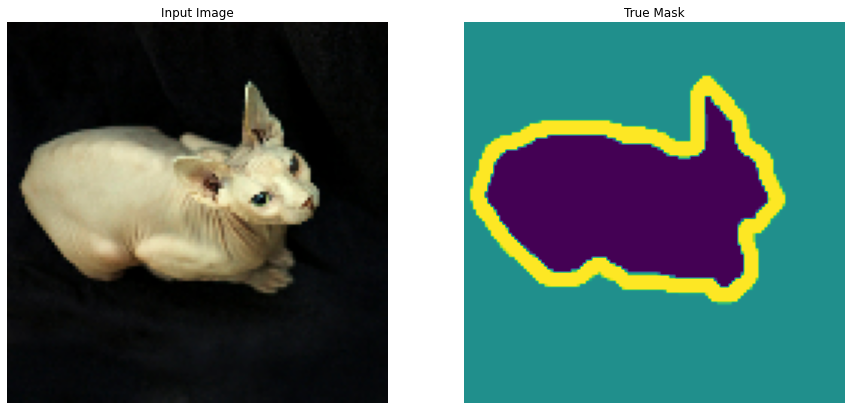

In [45]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

**Определение модели**

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
with tf.device('/gpu:0'):
  base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

  # Use the activations of these layers
  layer_names = [
      'block_1_expand_relu',   # 64x64x96
      'block_3_expand_relu',   # 32x32x144
      'block_6_expand_relu',   # 16x16x192
      'block_13_expand_relu',  # 8x8x576
      'block_16_project',      # 4x4x320
  ]
  layers = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

  down_stack.trainable = False

In [0]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

**Тренировка модели**

In [0]:
with tf.device('/gpu:0'):
  model = unet_model(OUTPUT_CHANNELS)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

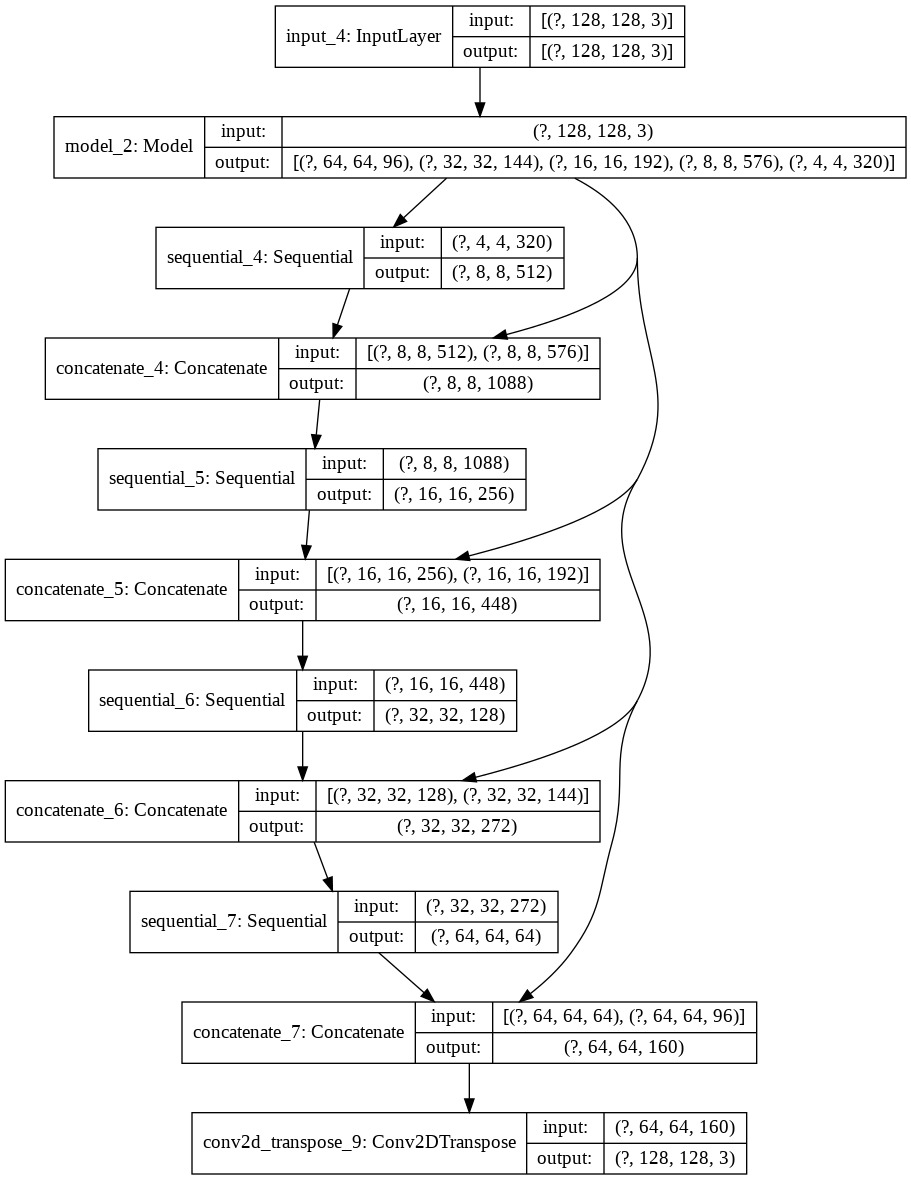

In [33]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

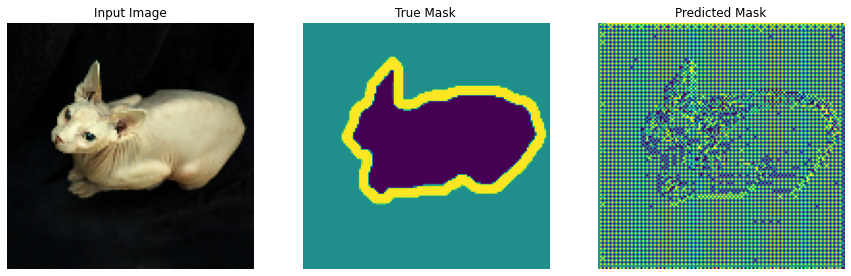

In [36]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [41]:
with tf.device('/gpu:0'):
  EPOCHS = 10 # увеличьте при необходимости
  VAL_SUBSPLITS = 5
  VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

  model_history = model.fit(train_dataset, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,
                            callbacks=[DisplayCallback()])

NameError: ignored

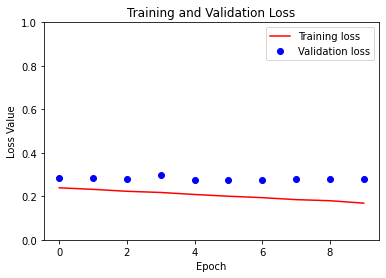

In [33]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

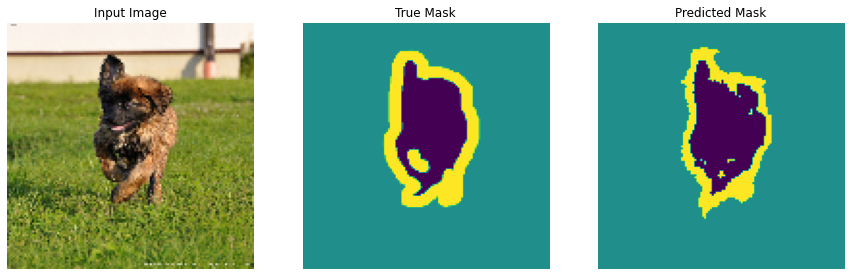

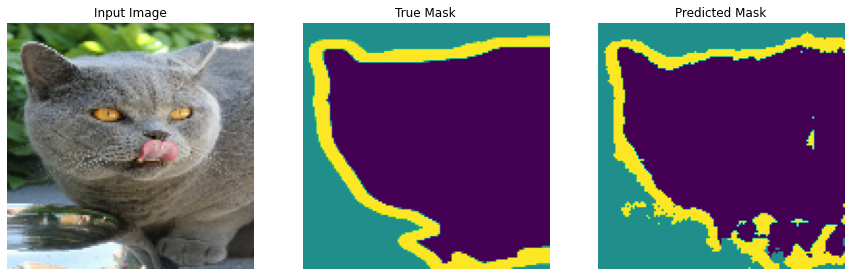

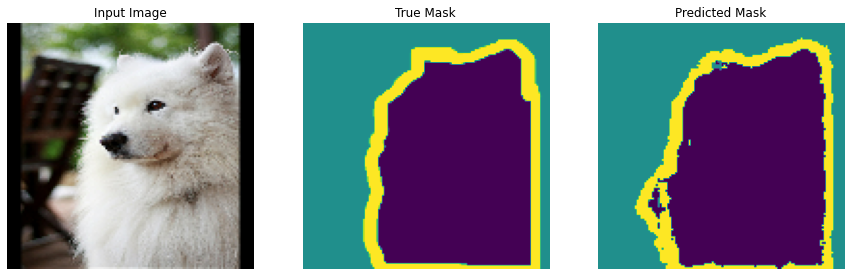

In [34]:
show_predictions(test_dataset, 3)

In [19]:
print(tf.data.experimental.cardinality(test))

tf.Tensor(3669, shape=(), dtype=int64)


### **Домашняя работа**

In [0]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import time

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(model):
  for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
  
  display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  # def __init__(self, model):
  #   super().__init__()
  #   self.model = model

  def _show_predictions(self):
    for image, mask in train.take(1):
      sample_image, sample_mask = image, mask
    
    display([sample_image, sample_mask,
             self._create_mask(self.model.predict(sample_image[tf.newaxis, ...]))])
  
  @staticmethod  
  def _create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

  def on_train_end(self, logs=None):
    self._show_predictions()

  def on_train_begin(self, logs=None):
    self.epoch = []
    self.history = {}

  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    self.epoch.append(epoch)
    for k, v in logs.items():
      self.history.setdefault(k, []).append(v)

In [0]:
def mobile_net_bb():
  with tf.device('/gpu:0'):
    base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64x96
        'block_3_expand_relu',   # 32x32x144
        'block_6_expand_relu',   # 16x16x192
        'block_13_expand_relu',  # 8x8x576
        'block_16_project',      # 4x4x320
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False

    return down_stack

In [0]:
def vgg16_bb():
  with tf.device('/gpu:0'):
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=[128, 128, 3], include_top=False)

    layer_names = [
                   'block2_conv1',
                   'block3_conv1',
                   'block4_conv1',
                   'block5_conv1',
                   'block5_pool'
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
    down_stack.trainable = False

    return down_stack

In [0]:
def resnet50v2_bb():
  with tf.device('/gpu:0'):
    base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=[128, 128, 3], include_top=False)

    layer_names = [
                  'conv1_conv',
                  'conv2_block1_1_relu',
                  'conv3_block1_1_relu',
                  'conv4_block2_2_relu',
                  'conv5_block1_2_relu'
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
    down_stack.trainable = False

    return down_stack

In [0]:
def densenet132_bb():
  with tf.device('/gpu:0'):
    base_model = tf.keras.applications.densenet.DenseNet121(input_shape=[128, 128, 3], include_top=False)

    layer_names = [
                  'conv1/relu',
                  'conv2_block1_0_relu',
                  'conv3_block1_0_relu',
                  'conv4_block1_0_relu',
                  'conv5_block1_0_relu'
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
    down_stack.trainable = False

    return down_stack

In [260]:
base_model.get_layer('conv1/relu')

In [0]:
base_model = tf.keras.applications.densenet.DenseNet121(input_shape=[128, 128, 3], include_top=False)
[base_model.layers[i].output for i in range(len(base_model.layers))]

In [0]:
def unet_model(output_channels, backbone=mobile_net_bb):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  
  down_stack = backbone()
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def create_nn(train_dataset, test_dataset, backbone=mobile_net_bb, optimizer='adam', n_epochs=10):
  with tf.device('/gpu:0'):
    output_channels = 3
    model = unet_model(output_channels, backbone=backbone)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    val_subsplits = 5
    validation_steps = info.splits['test'].num_examples//BATCH_SIZE//val_subsplits
    
    history = model.fit(train_dataset, epochs=n_epochs,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_steps=validation_steps,
                        validation_data=test_dataset,
                        verbose=0)
    
    return model, history

In [0]:
def evaluate_and_plot_results(train_dataset, test_dataset, params_list):
    for element in params_list:
        grid = ParameterGrid(element)
        accuracy_list = []
        time_list = []
        for param in grid:
            start = time.time()
            model, history = create_nn(train_dataset, test_dataset, **param)
            end = time.time()
            if 'backbone' in param.keys():
              print(param['backbone'].__name__)
            else:
              print(f'{list(param.keys())[0]}: {param[list(param.keys())[0]]}')
            show_predictions(model)
            accuracy = history.history['val_accuracy'][-1]
            accuracy_list.append(accuracy)
            time_list.append(end - start)
        
        to_print_acc = [float('{:.3f}'.format(x)) for x in accuracy_list]
        to_print_time = [float('{:.3f}'.format(x)) for x in time_list]
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 10))
        if 'backbone' in element.keys():
          ax1.barh([str(ele.__name__) for ele in list(element.values())[0]], accuracy_list, color='cornflowerblue')
          ax2.barh([str(ele.__name__) for ele in list(element.values())[0]], time_list, color='cornflowerblue')
        else:
          ax1.barh([str(ele) for ele in list(element.values())[0]], accuracy_list, color='cornflowerblue')
          ax2.barh([str(ele) for ele in list(element.values())[0]], time_list, color='cornflowerblue')
        ax1.set_xlim([0.75, 0.95])
        
        for i, v in enumerate(accuracy_list):
            if v == max(accuracy_list):
                ax1.text(v-(v-0.75)/2, 
                         i-len(accuracy_list)/80, 
                         to_print_acc[i], 
                         color='green', 
                         fontweight='bold', 
                         fontsize=18)
            elif v == min(accuracy_list):
                ax1.text(v-(v-0.75)/2, 
                         i-len(accuracy_list)/80, 
                         to_print_acc[i], 
                         color='red', 
                         fontweight='bold', 
                         fontsize=18)
            else:
                ax1.text(v-(v-0.75)/2, 
                         i-len(accuracy_list)/80, 
                         to_print_acc[i], 
                         color='black', 
                         fontweight='bold', 
                         fontsize=18)
        for i, v in enumerate(time_list):
            if v == max(time_list):
                ax2.text(v/2, i-len(time_list)/80, to_print_time[i], color='red', fontweight='bold', fontsize=18)
            elif v == min(time_list):
                ax2.text(v/2, i-len(time_list)/80, to_print_time[i], color='green', fontweight='bold', fontsize=18)
            else:
                ax2.text(v/2, i-len(time_list)/80, to_print_time[i], color='black', fontweight='bold', fontsize=18)

        ax1.set_xlabel('Точность')
        ax2.set_xlabel('Время обучения')
        ax1.grid(True)
        ax2.grid(True)
        plt.show()
        print('_' * 100)

In [0]:
param_list = [
              {'backbone': [mobile_net_bb, vgg16_bb, resnet50v2_bb, densenet132_bb]},
              {'optimizer': ['adam', 'sgd', 'adamax', 'nadam']},
              {'n_epochs': [2, 5, 10, 20]}
              ]

mobile_net_bb


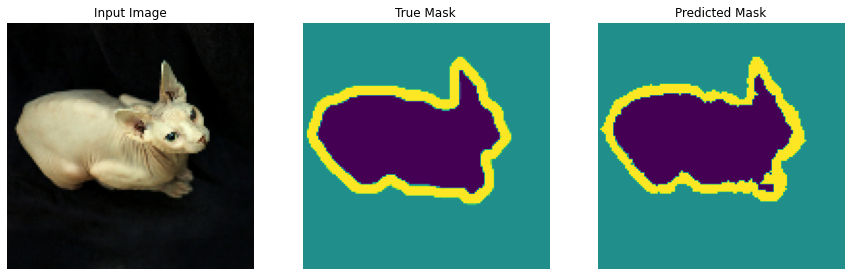

vgg16_bb


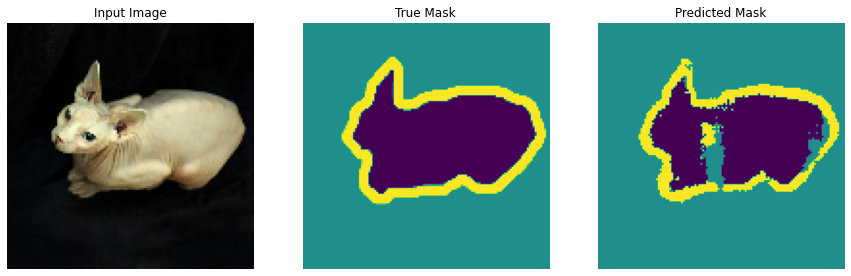

resnet50v2_bb


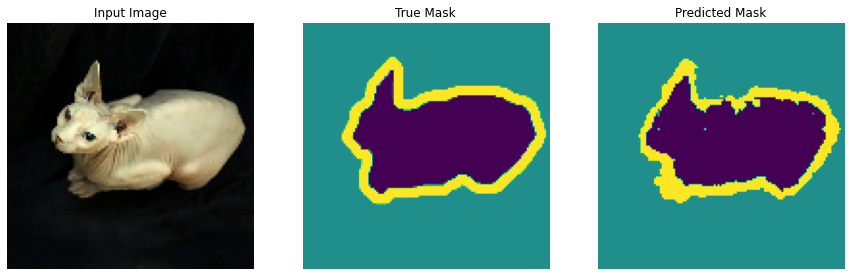

densenet132_bb


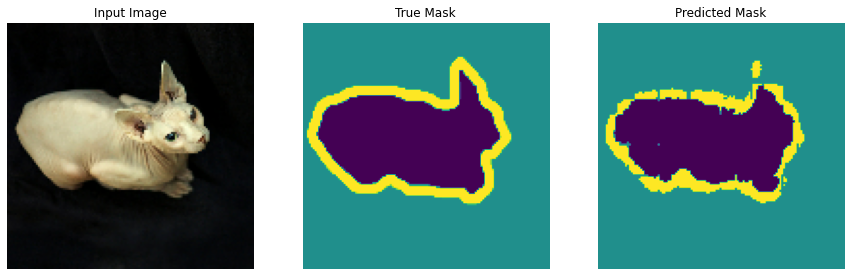

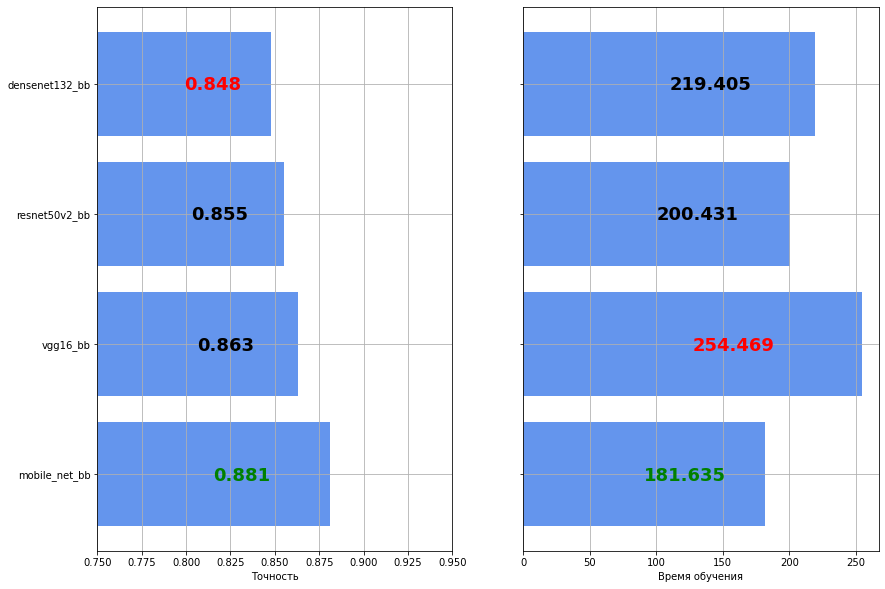

____________________________________________________________________________________________________
optimizer: adam


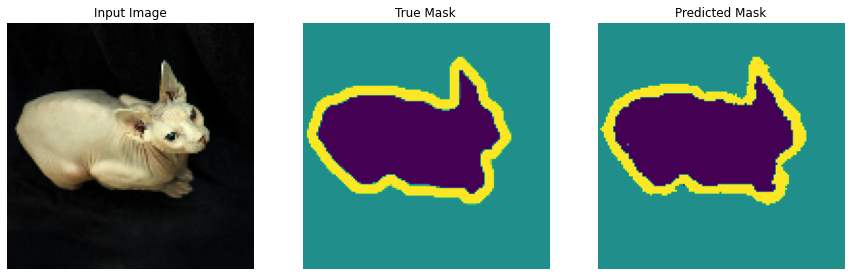

optimizer: sgd


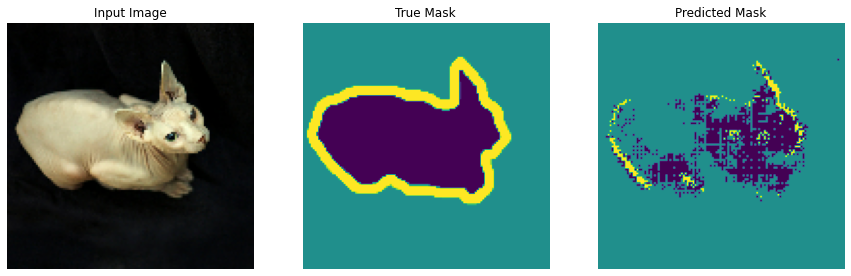

optimizer: adamax


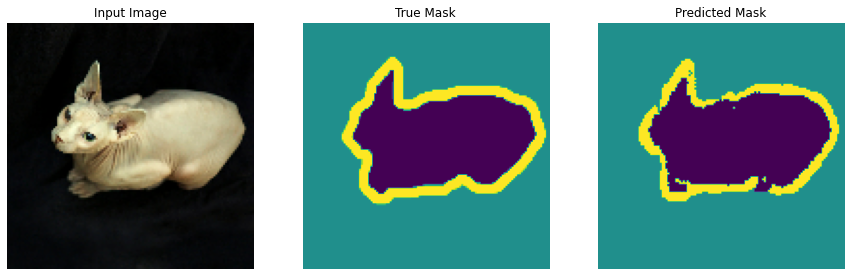

optimizer: nadam


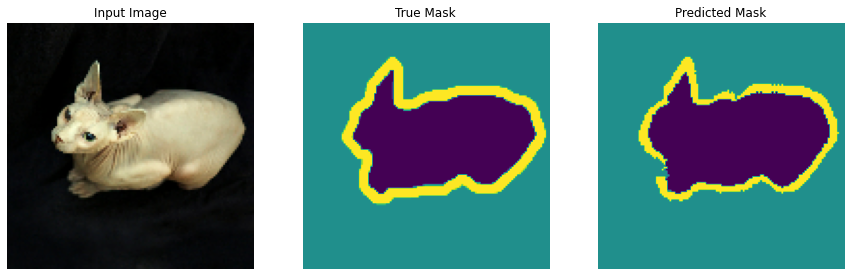

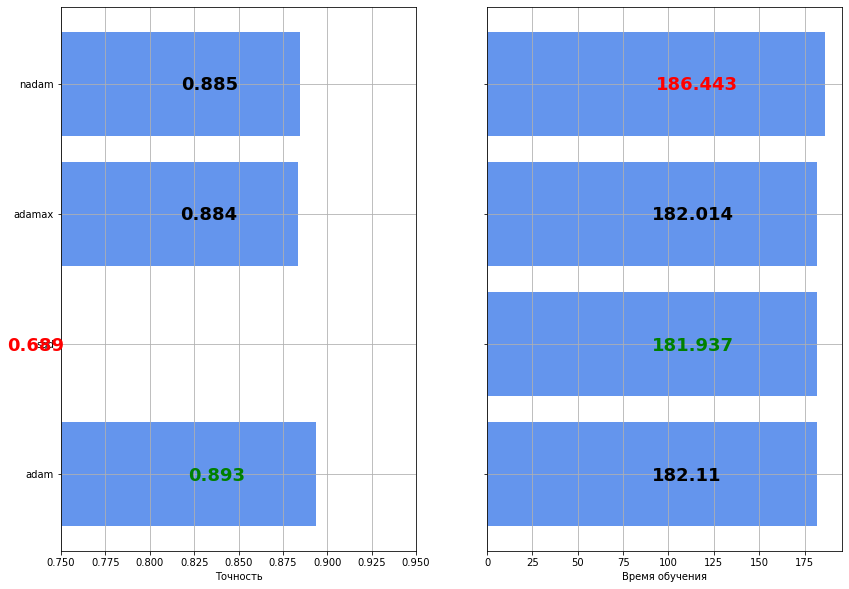

____________________________________________________________________________________________________
n_epochs: 2


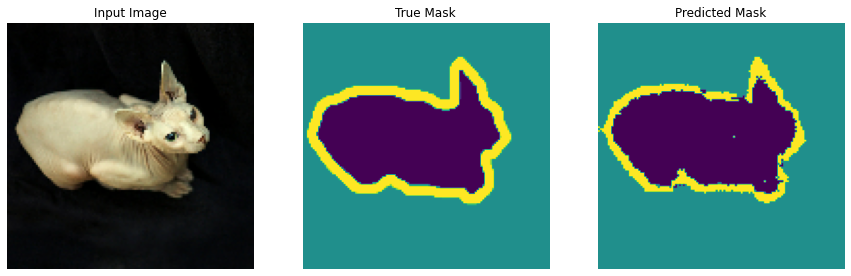

n_epochs: 5


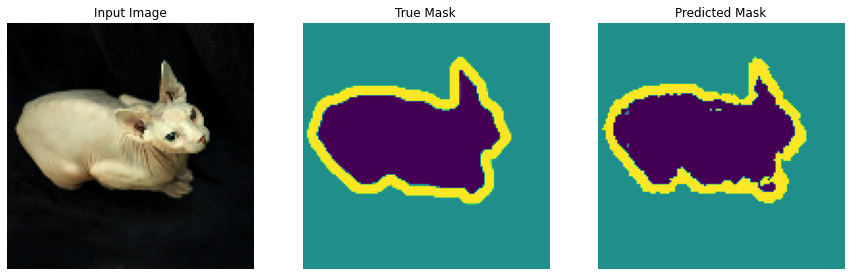

n_epochs: 10


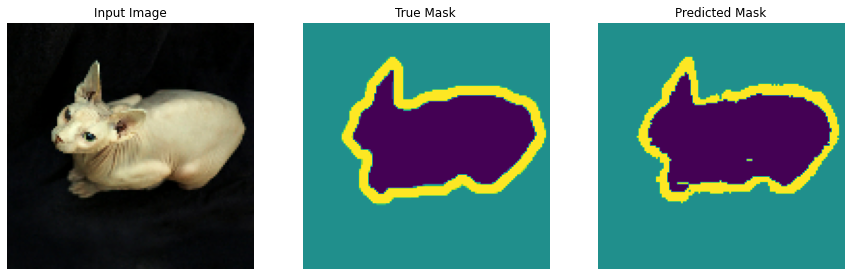

n_epochs: 20


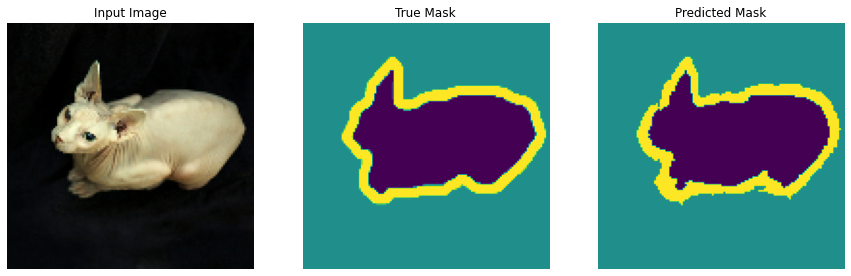

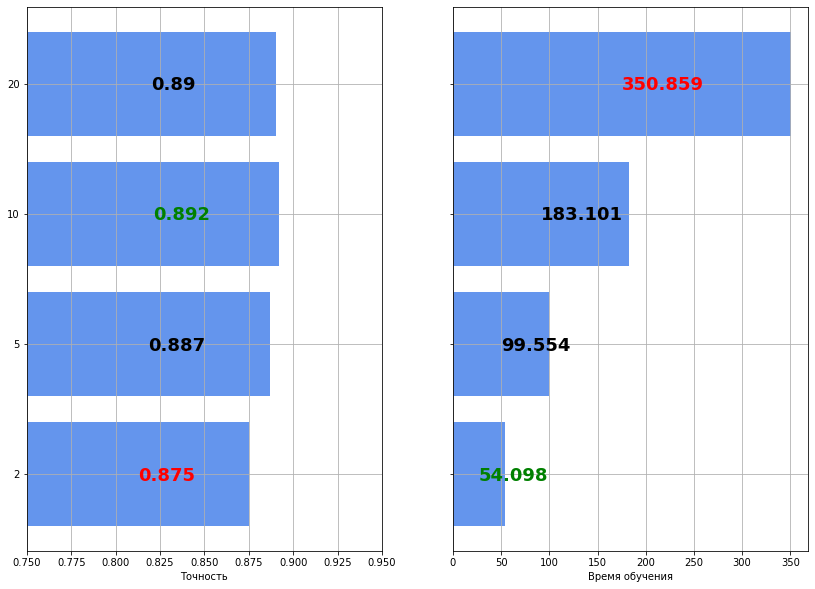

____________________________________________________________________________________________________


In [298]:
evaluate_and_plot_results(train_dataset, test_dataset, param_list)

#### **Выводы**

* Из 4 исследованных архитектур лучше всего себя показала изначально выбранная MobileNetV2, при этом так как это самая легкая модель, она оказалось и самой быстрой в обучении
* Из оптимайзеров лучше всего себя проявил тоже выбранный изначально adam при этом выбор оптимайзера почти не повлиял на время обучения
* Время обучения и точность, как и в других нейросетях, растет пропорциально количеству эпох обучения. После определенного значения (в данном случае после 10) увеличение количества эпох перестает давать положительный эффект